In [3]:
import math
import time

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
import cv2
import joblib
import tensorflow as tf
from keras.models import load_model
from keras import layers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Завдання

Частина 1

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

Частина 2

В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.


In [5]:
num_classes = 10
num_features = 28 * 28

learning_rate = 0.001
n_epochs = 20
batch_size = 512

In [5]:
from tensorflow.keras.datasets import fashion_mnist
data_set_fashion = fashion_mnist.load_data()

In [6]:
joblib.dump(data_set_fashion, "data_set_fashion")

['data_set_fashion']

In [6]:
data_set_fashion = joblib.load( "data_set_fashion")

In [7]:
class_to_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4 :"Coat",
    5: "Sandal",
    6 :"Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [7]:
(x_train_all, y_train_all), (x_test, y_test) = data_set_fashion
x_train_all, x_test = np.array(x_train_all, np.float32), np.array(x_test, np.float32)
x_train_all, x_test = x_train_all / 255., x_test / 255.


'Sneaker'

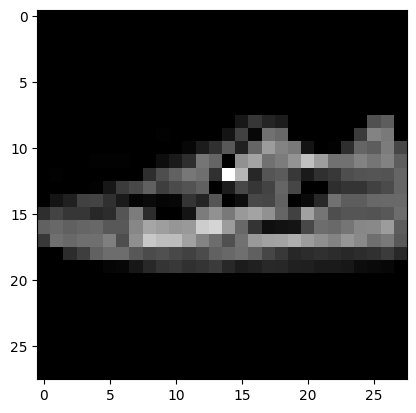

In [8]:
i_sample = 10001
plt.imshow(x_train_all[i_sample], cmap="gray")
class_to_label[y_train_all[i_sample]]

In [2]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.2, shuffle=True)

NameError: name 'x_train_all' is not defined

In [14]:
x_train.shape , x_valid.shape

((48000, 28, 28), (12000, 28, 28))

In [13]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256, transforms=None):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size
        self.transforms = transforms

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        # batch_x = [self.x[i].reshape(num_features) for i in indexes]
        batch_x = [self.x[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], num_classes) for i in indexes]


        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [7]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_conv.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [15]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)


In [16]:
model = Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),

    layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=[CategoricalAccuracy()],
)

In [19]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    verbose=1,
    callbacks=[callback_save, callback_early_stopping]
)

Epoch 1/30


2023-08-15 08:14:17.167346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-15 08:14:19.865532: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd82402b1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 08:14:19.865590: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2023-08-15 08:14:19.969977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 08:14:20.473309: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/94 [============================>.] - ETA: 0s - loss: 0.9761 - categorical_accuracy: 0.6390
Epoch 1: val_loss improved from inf to 0.62668, saving model to best_conv.hdf5
94/94 [==============================] - 12s 37ms/step - loss: 0.9721 - categorical_accuracy: 0.6405 - val_loss: 0.6267 - val_categorical_accuracy: 0.7732
Epoch 2/30
 5/94 [>.............................] - ETA: 2s - loss: 0.6019 - categorical_accuracy: 0.7793

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - ETA: 0s - loss: 0.5168 - categorical_accuracy: 0.8075
Epoch 2: val_loss improved from 0.62668 to 0.48369, saving model to best_conv.hdf5
94/94 [==============================] - 3s 28ms/step - loss: 0.5168 - categorical_accuracy: 0.8075 - val_loss: 0.4837 - val_categorical_accuracy: 0.8238
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 0.4193 - categorical_accuracy: 0.8454
Epoch 3: val_loss improved from 0.48369 to 0.36998, saving model to best_conv.hdf5
94/94 [==============================] - 3s 29ms/step - loss: 0.4193 - categorical_accuracy: 0.8454 - val_loss: 0.3700 - val_categorical_accuracy: 0.8689
Epoch 4/30
93/94 [============================>.] - ETA: 0s - loss: 0.3605 - categorical_accuracy: 0.8666
Epoch 4: val_loss improved from 0.36998 to 0.36401, saving model to best_conv.hdf5
94/94 [==============================] - 3s 28ms/step - loss: 0.3608 - categorical_accuracy: 0.8665 - val_loss: 0.3640 - val_categorical

In [21]:
# best_model = tf.keras.saving.load_model("best_conv.hdf5")
# test_out = best_model(x_test).numpy()
test_out = model(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)
print(f"Accuracy test data: {accuracy_test.round(4)}" )

2023-08-15 08:17:25.755658: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-15 08:17:25.755719: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-08-15 08:17:26.397107: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-15 08:17:26.397199: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of 

Accuracy test data: 0.9101


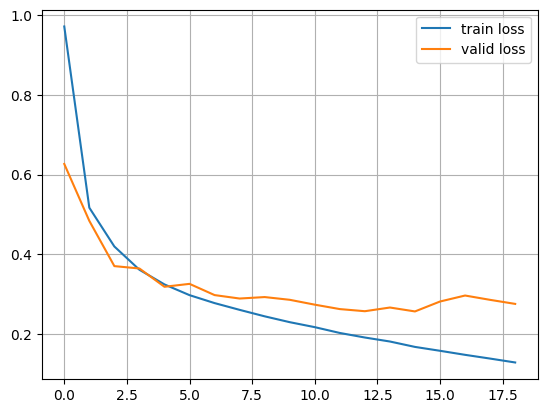

In [22]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.grid()

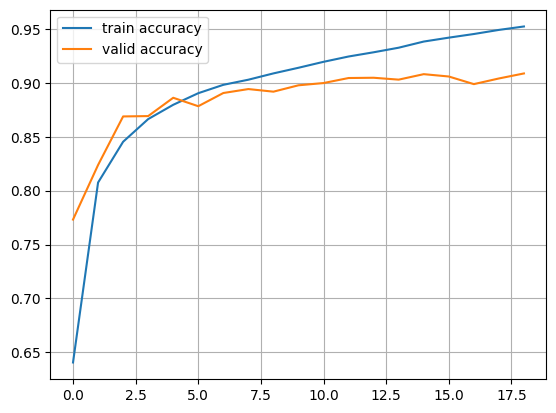

In [23]:
plt.plot(history.history["categorical_accuracy"], label="train accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="valid accuracy")
plt.legend()
plt.grid()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [8]:
#Create dataset with VGG16 standart - 224x224x3
(x_train_all, y_train_all), (x_test_vgg, y_test_vgg) = data_set_fashion

In [9]:
x_train_vgg, x_valid_vgg, y_train_vgg, y_valid_vgg = train_test_split(x_train_all, y_train_all, test_size=0.2, shuffle=True)

Trouser (28, 28)


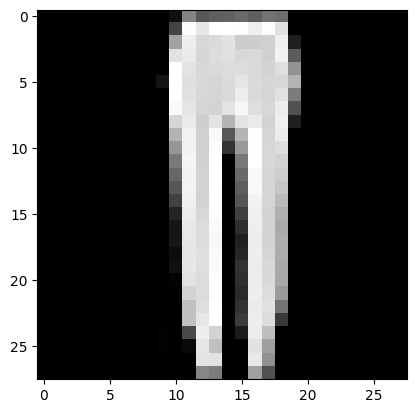

In [10]:
i_sample = 100
plt.imshow(x_train_vgg[i_sample], cmap="gray")
x_train_vgg
print(class_to_label[y_train_vgg[i_sample]], x_train_vgg[i_sample].shape)


In [11]:
class Dataset_vgg16(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256, transforms=None):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size
        self.transforms = transforms

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], num_classes) for i in indexes]
        batch_X = []
        for i in indexes:
            img = np.asarray(Image.fromarray(np.uint8(self.x[i])).convert('RGB'))
            if self.transforms:
                img = self.transforms(image=img)["image"]
            
            batch_X.append(img)

        return np.array(batch_X) / 255., np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [12]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Resize(224, 224, p=1.),
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(224, 224, p=1.),
    ]
)
test_transforms = A.Compose(
    [
        A.Resize(224, 224, p=1.),
    ]
)

In [21]:
train_dataset = Dataset_vgg16(x_train_vgg, y_train_vgg, shuffle=True, batch_size=128, transforms=train_transforms)
valid_dataset = Dataset_vgg16(x_valid_vgg, y_valid_vgg, shuffle=False, batch_size=128, transforms=valid_transforms)
test_dataset = Dataset_vgg16(x_test_vgg, y_test_vgg, shuffle=False, batch_size=16, transforms=valid_transforms)

In [39]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

model_vgg = Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(512, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model_vgg.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=[CategoricalAccuracy()]
)

In [14]:
X, y = test_dataset[0]
X.shape, y.shape

((16, 224, 224, 3), (16, 10))

In [40]:
model_vgg.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 27565386 (105.15 MB)
Trainable params: 12850698 (49.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
callback_early_stopping = EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=2,
    verbose=1,
    mode="max"
)


callback_save = ModelCheckpoint(
    "best_vgg16.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [59]:
history = model_vgg.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    verbose=1,
    callbacks=[callback_early_stopping, callback_save]
)

Epoch 1/20


2023-08-16 11:08:05.208340: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 677.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-16 11:08:05.407992: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 677.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-16 11:08:05.408068: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-16 11:08:05.467628: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator 

375/375 [==============================] - ETA: 0s - loss: 0.7593 - categorical_accuracy: 0.7639
Epoch 1: val_loss improved from inf to 0.42302, saving model to best_vgg16.hdf5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 321s 806ms/step - loss: 0.7593 - categorical_accuracy: 0.7639 - val_loss: 0.4230 - val_categorical_accuracy: 0.8525
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.4731 - categorical_accuracy: 0.8362
Epoch 2: val_loss improved from 0.42302 to 0.35839, saving model to best_vgg16.hdf5
375/375 [==============================] - 293s 781ms/step - loss: 0.4731 - categorical_accuracy: 0.8362 - val_loss: 0.3584 - val_categorical_accuracy: 0.8723
Epoch 3/20
375/375 [==============================] - ETA: 0s - loss: 0.4220 - categorical_accuracy: 0.8543
Epoch 3: val_loss improved from 0.35839 to 0.34477, saving model to best_vgg16.hdf5
375/375 [==============================] - 265s 707ms/step - loss: 0.4220 - categorical_accuracy: 0.8543 - val_loss: 0.3448 - val_categorical_accuracy: 0.8774
Epoch 4/20
375/375 [==============================] - ETA: 0s - loss: 0.3915 - categorical_accuracy: 0.8613
Epoch 4: val_loss improved from

In [37]:
start_time = time.time()
best_model_vgg = tf.keras.saving.load_model("best_vgg16.hdf5")
test_out = []

for x, y in test_dataset:
    test_out.extend(best_model_vgg(x).numpy())
print(len(test_out))
    

test_out = np.array(test_out)
end_time = time.time()
execution_time = end_time - start_time
print("Час виконання: ", execution_time, "секунд")
test_out.shape

10000
Час виконання:  80.42437815666199 секунд


(10000, 10)

In [38]:
accuracy_test_vgg = np.mean(test_out.argmax(axis=1) == y_test_vgg)
print(f"Accuracy test data: {accuracy_test_vgg.round(4)}" )

Accuracy test data: 0.8968


# Conclusion

Best params flatten NN:
1. learning_rate = 0.0005
1. n_units = [4000, 80]
1. batch_size = 512
1. layers = 2
1. activate_funcion = "relu"
1. optimizer = "AdamW"
1. Dropout = 0.3

Final accuracy = 0.8943

 Best params Convolutional NN:

1. batch_size = 512
1. activate_funcion = "relu"
1. optimizer = "rmsprop"

Final accuracy = 0.9117

Best params VGG16:

1. Input shape 224x224x3 
1. Dense = 512
1. activate_funcion = "relu"
1. optimizer = "rmsprop"

Final accuracy = 0.8968

Conclusion: The best result has custom Convolutional NN, because dataset is grayscale and have small size. Flatten NN not match for this calculation and VGG16 have too many convertation and pre-learn due to universal data, That is why they have worse results.